# Runtime i instalacja

Zacznijmy od włączenia wsparcia obliczeń kartą graficzną (GPU), która znacznie przyspieszy nasze działania. Może się zdażyć, że nie będzie dostępnych GPU w Colaboratory – wtedy można pracować bez niego, jedynie obliczenia potrwają kilka razy dłużej.

Wybieramy w menu **`Runtime`** -> **`Change runtime type`** , a następnie w podmenu **`Hardware accelerator`** wybieramy **`GPU`**.


<img style="float:left" src="https://www.mimuw.edu.pl/~mm319369/priv/d73890416bec03ff3e2b3756af8c941c/images/change-runtime1.png">
<img src="https://www.mimuw.edu.pl/~mm319369/priv/d73890416bec03ff3e2b3756af8c941c/images/change-runtime2.png">

## TFlearn

W tym zadaniu będziemy uczyć sieci neuronowe i obserwować jak zachowują się, gdy zmieniamy liczbę neuronów w sieci, funkcje aktywacji i co się dzieje, gdy sieć jest za duża względem danych. Wasze zadanie będzie polegało na odpowiedniej konfiguracji sieci, a następnie narysowaniu wykresów zaobserwowanych rezultatów.

Będziemy korzystać z biblioteki [*tflearn*](http://tflearn.org/getting_started/), która jest prostym interfejsem do `tensorflow`.

Poniżej ją instalujemy i importujemy potrzebne biblioteki.

In [1]:
!pip install tflearn tensorflow

fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.0.0 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from __future__ import division, print_function, absolute_import

import time
import math

import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Monkey-patchujemy tflearn, żeby nie wypisywał samemu statystyk,
# któe nie działają dobrze w colaboratory
tflearn.callbacks.TermLogger.print_termlogs = lambda *args, **kwargs: None

# Zbiór danych (dataset)

Będziemy pracować na już tradycyjnym zbiorze – rozpoznawania odręcznie pisanych cyfr [MNIST](http://yann.lecun.com/exdb/mnist/).
Elementy tego zbioru to obrazki 28x28 pikseli w skali szarości, a ich etykietami są cyfry im odpowiadające. Mamy 55000 przykładów treningowych i 10000 przykładów testowych.
Dla wydajności obliczeń, wszystkie dane są umieszczane w dużych macierzach (tablicach).

Poniższa komórka pobiera i ładuje zbiór danych do pamięci. Wyjaśnienie wprowadzonych zmiennych poniżej.


In [3]:
# Tu ładujemy nasz dataset - zestaw odręcznie pisanych cyfr od 0 do 9


import tflearn.datasets.mnist as mnist
X, Y, testX, testY = mnist.load_data(one_hot=True) # ładowanie datasetu (automatycznie ściąga się z internetu)

# X,Y to dane treningowe
# testX, textY to dane walidacyjne - sprawdzamy nimi jak dobra jest nasza sieć

# nasze obrazy mają mieć wymiar 28x28 pikseli - będziemy używać sieci konwolucyjnych, więc konieczna 
# jest zmiana wymiarów macierzy poleceniem reshape
# [samples, x_size, y_size, channels]
# samples - liczba próbek 
# x_size, y_size - wymiary obrazka
# channels - liczba kolorów/kanałów - w naszym przypadku 1, bo obrazki są czarno-białe
X = X.reshape([-1, 28, 28, 1])
testX = testX.reshape([-1, 28, 28, 1])

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


**X** oraz **testX** to 4-wymiarowe macierze z przykładami odpowiednio treningowymi i testowymi. Wymiary tych macierzy to \[*liczba przykładów*, *rozmiar x*, *rozmiar y*, *liczba kolorów*]. Różne funkcje oczekują odpowiednich wymiarów macierzy. Nie będzie to na szczęście dla nas istotne poza zrozumieniem napisów, które się pojawiają:

`X[4]`  - przykład numer 4 (wymiar [28, 28, 1]) \\
`X[2:3]`  - przykład numer 2, ale w wymiarze [1, 28, 28, 1] - odpowiednie dla funkcji/metod tflearn \\
`X[:10]`  - przykłady numer 0...9, w wymiarze [10, 28, 28, 1] \\
`X[2,:,:,0]` - przykład 2 w w wymiarze [28, 28] odpowiednim dla funkcji do rysowania

**Y** oraz **testY** to 2-wymiarowe macierze z etykietami odpowiednio treningowymi i testowymi. Wymiary tych macierzy to \[*liczba przykładów*, *liczba cyfr*]. Te macierze reprezentują tzw. kodowanie *one-hot* etykiet  - dany przykład przedstawiający cyfrę **i** ma **1** na **i**-tej pozycji, a na pozostałych **0**.

`Y[0]` - etykieta przykładu numer 0 (wymiar [10]) \\
`Y[2:3]` - etykieta przykładu numer 2, ale w wymiarze [1, 10] - odpowiednie dla funkcji/metod tflearn \\
`Y[:10]` - etykiety dla przykładów numer 0..9 (j.w.)

Poniżej przykład użycia na przykładach numer 0 i 1 (powinny reprezentować 7 i 3).

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


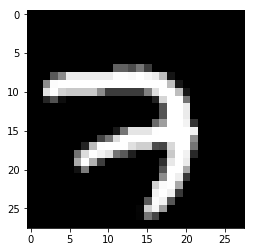

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


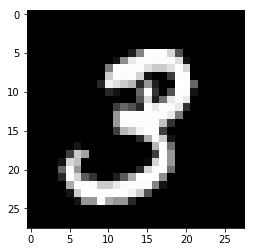

In [4]:
# Kilka przykładów z naszego datasetu
print(Y[0]) # etykieta - 1 tam, gdzie poprawna klasa
plt.imshow(X[0,:,:,0], cmap='gray') # reprezentacja graficzna obrazka
plt.show()

print(Y[1])
plt.imshow(X[1,:,:,0], cmap='gray')
plt.show()

# Budowa sieci

Zdefiniujmy najpierw klasę pomocniczną, która będzie przetrzymywać wyniki obliczeń i przyda nam się do wykresów. Opiszemy ją później.

In [5]:
# Definiujemy klasę, która będzie przetrzymywać wyniki obliczeń po każdej epoce
class Stats(tflearn.callbacks.Callback):
    def __init__(self, examples=0):
        self.epoch_data = []
        self.data_size = examples
        self.last_time = 0
        self.start_time = 0
        
        self.min_report_secs = 1.

    def on_train_begin(self, training_state):
        self.start_time = time.time()
      
    def on_epoch_end(self, training_state):
        metrics = {
            'loss': training_state.loss_value, # loss (strata) dla danych treningowych
            'acc': training_state.acc_value,   # accuracy (dokładność) dla danych treningowych
            'val_loss': training_state.val_loss, # loss dla danych walidacyjnych
            'val_acc': training_state.val_acc, # accuracy dla danych walidacyjnych
            'epoch': training_state.epoch,
            'step': training_state.step,
            'iter': training_state.current_iter,
            'time': time.time() - self.start_time,
        }

        self.epoch_data.append(metrics)
        
    def on_batch_end(self, training_state, snapshot=False):
      cur_time = time.time()
      if cur_time - self.last_time < self.min_report_secs:
        return # nie spamujmy za często
      
      self.last_time = cur_time
      epoch = training_state.epoch
      step = training_state.step
      iter = training_state.current_iter
      print("Epoch %d, step (batch no.): %d -- acc: %.2f, loss %.2f -- iter %05d/%05d, training for: %.2fs" % (
          epoch, step, training_state.acc_value, training_state.loss_value,
          iter, self.data_size, cur_time-self.start_time))

\\

Poniżej jest przykład budowy sieci przy korzystaniu z `tflearn`. W zadaniu będzie trzeba zmieniać odpowiednie parametry.

Sieć budujemy kolejnymi warstwami, gdzie funkcja tworząca następną warstwę przyjmuje zmienną reprezentującą poprzednią. Dla wygody wynik przypisujemy na tą samą zmienną, aby móc łatwo dodawać dodatkowe warstwy poprzez wklejenie kodu w odpowiednie miejsce:

`network = ...` <- opis warstwy A \\
`network = conv_2d(network, ...)` <- tworzymy nową warstwę B za warstwą A i przypisujemy na tą samą zmienną (nie potrzebujemy już odwoływać się do warstwy A) \\
`network = fully_connected(network, ...)` <- warstwa C za warstwą B

W tym momencie zmienna `network` reprezentuje sieć składającą się z warstw `A-B-C`.

### Uczenie

Uczenie sieci przebiega w fazach. Podajemy sieci przykłady kolejno i stosujemy propagację wstęczną. W momencie, gdy przykłady nam się skończą, po prostu zaczynamy od nowa. Każdy taki obrót będziemy nazywali **epoką**.  \\
Przykładów nie będziemy podawać sieci pojedynczo – podajemy je w porcjach rozmiaru `batch` (*wsad*), co oznacza ile przykładów sieć będzie przetwarzać jednocześnie.

Przydatne nam będą przede wszystkim funkcje:

`conv_2d(network, #filtrów, #rozmiar, activation=f.aktywacji, regularizer="L2")` - tworzy nową warstwę konwolucyjną posiadającą `#filtrów` filtrów (neuronów) o rozmiarze `#rozmiar x #rozmiar` oraz z funkcją aktywacji jak podana. Wartości `regularizer` nie należy zmieniać w tym zadaniu.

`max_pool_2d(network, #rozmiar)` - podpróbkowanie danych co `#rozmiar` (zmniejsza wymiar obrazka razy `#rozmiar`)

`fully_connected(network, #neuronów, activation=f.aktywacji)` - warstwa pełna  z `#neuronów` neuronów i podaną funkcją aktywacji.

**W kodzie zaznaczono, który fragment będzie podlegał modyfikacji.**

In [6]:
# Tu definiujemy architekturę naszej sieci

# !!! UWAGA - przy każdych nowych obliczeniach należy zresetować graf sieci
tf.reset_default_graph()

# Wyłączamy warningi z tensorflow
tf.logging.set_verbosity(tf.logging.ERROR)


# Warstwa wejściowa - musi mieć takie same wymiary jak dane
network = input_data(shape=[None, 28, 28, 1], name='input') # None oznacza, że ta 
# wartość będzie uzupełniona automatyzcnie i jest to liczba próbek we wsadzie (batch)

### MODYFIKUJEMY ODTĄD
# ---
# Pierwsza warstwa konwolucyjna - 32 filtry o rozmiarach 3x3
# z funkcją aktywacji (activation=) relu.
# Regularizer='L2' oznacza narzucenie ograniczenia na wartości wag (nie istotne tutaj).
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
# max_pool wykonuje podpróbkowanie danych - zmniejsza wymiar obrazka 2-krotnie
network = max_pool_2d(network, 2) # teraz obrazki są [14x14]

# druga warstwa konwolucyjna - 32 filtry o rozmiarach 3x3 z podpróbkowaniem
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2) # teraz obrazki są [7x7]

# warstwa pełna - tu już zaczyna się "normalna" sieć neuronowa
network = fully_connected(network, 128, activation='relu') # 128 neuronów, aktywacja "relu", przyjmuje wejście [7x7] do [128] neuronów
network = fully_connected(network, 256, activation='relu') # 256 neuronów, aktywacja "relu"
# ---
### DOTĄD

# warstwa wyjściowa - używamy aktywacji softmax, żeby dostać prawdopodobieństwa dla każdej klasy (cyfry)
network = fully_connected(network, 10, activation='softmax')

# tu definiujemy w jaki sposób optymalizować sieć (regression nie oznacza, że robimy regresję)
# nie będziemy modyfikować tych argumentów; stosujemy optymizator Adam
network = regression(network, optimizer='adam', learning_rate=0.01,
                     batch_size=250,
                     loss='categorical_crossentropy', name='target')

Powyżej zdefiniowaliśmy sieć z warstwą wejściową, dwiema warstwami konwolucyjnymi z 32 filtrami 3x3 i podpróbkowaniem x2 oraz trzema warstwami pełnymi z odpowiednio 128, 256 i 10 neuronami.

## Trenowanie sieci

Trenowanie sieci wywołujemy jak poniżej (wszystkie 3 linijki będą potrzebne). Trenowanie możemy w dowolnym momencie przerwać klikając na kwadrat zatrzymywania.

Metoda uczenia ma następującą sygnaturę:
`model.fit({'input': X}, {'target': Y}, n_epoch=#epok,
           validation_set=({'input': testX}, {'target': testY}), show_metric=True, callbacks=[scores])`
  
 Uczy podaną wyżej sieć, z danymi treningowymi z `X` i etykietami z `Y` przez `#epok` epok. Wyniki walidacji będą obliczane na zbiorze testowym `testX` z etykietami `testY`. Resztę zostawiamy bez zmian – służy do wypisywania i rejestrowania statystyk.

Podczas uczenia będziemy zbierali miary tego, jak sieć radzi sobie z naszymi danymi:

 `loss` - loss (strata) dla danych treningowych \\
`acc` - accuracy (dokładność) dla danych treningowych \\
`val_loss` -  loss dla danych walidacyjnych \\
`val_acc` - accuracy dla danych walidacyjnych \\
`epoch` - numer *epoki* \\
`step` - numer wsadu (*batch*) \\
`iter` - liczba widzianych przykładów \\
`time` - czas jaki upłynął od początku uczenia \\
  

**Uwaga!** kolejne wywołania poniższej komórki będą *douczać* sieć – aby uczyć ją od nowa musimy ponownie wykonać komórkę z definicją sieci.

In [ ]:
# uruchamiamy trenowanie naszej sieci
# n_epoch - liczba epok, czyli przejść przez cały zbiór danych treningowych
scores = Stats(examples=len(X))
model = tflearn.DNN(network, tensorboard_verbose=0)
model.fit({'input': X}, {'target': Y},
          n_epoch=20,  # <-- DO ZMIANY
          validation_set=({'input': testX}, {'target': testY}), show_metric=True, callbacks=[scores])


---------------------------------
Run id: 7Z8TYV
Log directory: /tmp/tflearn_logs/
---------------------------------
Training samples: 55000
Validation samples: 10000
--
Epoch 1, step (batch no.): 1 -- acc: 0.00, loss 0.00 -- iter 00250/55000, training for: 0.25s
Epoch 1, step (batch no.): 14 -- acc: 0.68, loss 0.94 -- iter 03500/55000, training for: 1.27s
Epoch 1, step (batch no.): 27 -- acc: 0.90, loss 0.35 -- iter 06750/55000, training for: 2.29s
Epoch 1, step (batch no.): 41 -- acc: 0.93, loss 0.22 -- iter 10250/55000, training for: 3.35s
Epoch 1, step (batch no.): 54 -- acc: 0.95, loss 0.16 -- iter 13500/55000, training for: 4.38s
Epoch 1, step (batch no.): 68 -- acc: 0.96, loss 0.12 -- iter 17000/55000, training for: 5.44s
Epoch 1, step (batch no.): 81 -- acc: 0.97, loss 0.10 -- iter 20250/55000, training for: 6.48s
Epoch 1, step (batch no.): 95 -- acc: 0.97, loss 0.10 -- iter 23750/55000, training for: 7.55s
Epoch 1, step (batch no.): 108 -- acc: 0.96, loss 0.12 -- iter 27000/55

## Korzystanie z sieci

Poniźej przykład korzystania z sieci do etykietowania danych które sieć nie widziała.

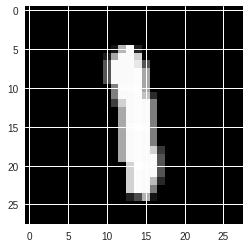

[[3.8674139e-04 9.9780029e-01 2.0808993e-04 9.8275334e-05 9.9644603e-05
  2.5409934e-04 8.5919666e-05 9.4099181e-05 9.6899917e-04 3.9085426e-06]]
Prawdopodobnie: 1 na 99.780%


In [15]:
# Wylosujmy index elementu ze zbioru testowego do sprawdzenia
test_index = np.random.randint(len(testX))
# Przewidywania modelu na danych walidacyjnych (prawdopodobieństwa/logika rozmyta):
predictions = model.predict(testX[test_index:test_index+1])
plt.imshow(testX[test_index,:,:,0], cmap='gray')
plt.show()
print(predictions)
print("Prawdopodobnie: %s na %.3f%%" % (predictions.argmax(), predictions.max()*100))

# Programatyczny dostęp do statystyk

Statystyki znajdziemy w obiekcie `scores`, który przekazaliśmy podczas uczenia sieci. Jest to lista statystyk po każdej *epoce*. Statystyki reprezentowane są przez słownik z polami jak opisanymi wcześniej.

In [0]:
# wyświetlenie danych
scores.epoch_data

# POLECENIA
## Do zaliczenia tego zadania można zrobić podzadania A-C lub zadanie alternatywne.

# Uwagi:

### Przy każdych nowych obliczeniach należy zresetować graf sieci.
### Nie należy zmieniać linijki z optymizatorem przy rozwiązywaniu zadań.
### Niektóre rezultaty mogą być nieintuicyjne.

# Zadanie A: dawne ograniczenia

Narysuj wykres zależności accuracy dla danych **walidacyjnych** od liczby epok (max 10 epok)
dla sieci w dwóch wariantach:
* 1 warstwa konwolucyjna: 32 filtry 3x3 + 2 warstwy pełne (jak w przykładzie: 128,256,10)


In [0]:
liczba_epok=10

In [0]:
tf.reset_default_graph()

tf.logging.set_verbosity(tf.logging.ERROR)
### Warstwy odtąd
network = input_data(shape=[None, 28, 28, 1], name='input')

network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")

network = fully_connected(network, 128, activation='relu') 
network = fully_connected(network, 256, activation='relu')

network = fully_connected(network, 10, activation='softmax')
### Warstwy dotąd

network = regression(network, optimizer='adam', learning_rate=0.01,
                     batch_size=250,
                     loss='categorical_crossentropy', name='target')

In [0]:
### Proces trenowania
liczba_epok = 10
scores = Stats(examples=len(X))
model = tflearn.DNN(network, tensorboard_verbose=0)
model.fit({'input': X}, {'target': Y},
          n_epoch=liczba_epok, 
          validation_set=({'input': testX}, {'target': testY}), show_metric=True, callbacks=[scores])

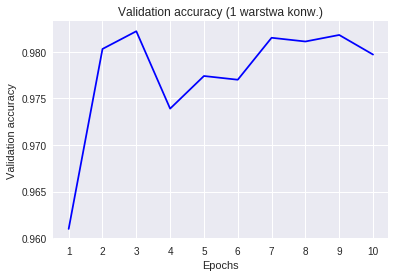

AttributeError: ignored

In [58]:
### Wykres val_acc jako funkcja epoch
val_acc = [scores.epoch_data[i]['val_acc'] for i in range(len(scores.epoch_data))]

epochs = [scores.epoch_data[i]['epoch'] for i in range(len(scores.epoch_data))]

plt.plot(epochs, val_acc, 'b')
plt.title('Validation accuracy (1 warstwa konw.)')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.xticks(np.arange(1, liczba_epok+1, step=1))
plt.show()

* j.w. ale dla 3 i 5 warstw konwolucyjnych (podpróbkowanie wykonuj tylko po 2. i 4. warstwie konwolucyjnej)

>> 3 warstwy konwolucyjne, po drugiej występuje podpróbkowanie

In [0]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.ERROR)

### Warstwy odtąd
network = input_data(shape=[None, 28, 28, 1], name='input')

network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")

network = fully_connected(network, 128, activation='relu') 
network = fully_connected(network, 256, activation='relu')

network = fully_connected(network, 10, activation='softmax')
### Warstwy dotąd

network = regression(network, optimizer='adam', learning_rate=0.01,
                     batch_size=250,
                     loss='categorical_crossentropy', name='target')

In [0]:
### Proces trenowania
scores = Stats(examples=len(X))
model = tflearn.DNN(network, tensorboard_verbose=0)
model.fit({'input': X}, {'target': Y},
          n_epoch=liczba_epok, 
          validation_set=({'input': testX}, {'target': testY}), show_metric=True, callbacks=[scores])

No handles with labels found to put in legend.


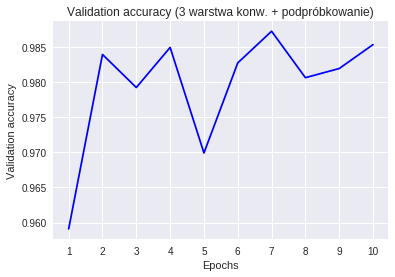

In [66]:
### Wykres val_acc jako funkcja epoch
val_acc = [scores.epoch_data[i]['val_acc'] for i in range(len(scores.epoch_data))]

epochs = [scores.epoch_data[i]['epoch'] for i in range(len(scores.epoch_data))]

plt.plot(epochs, val_acc, 'b')
plt.title('Validation accuracy (3 warstwa konw. + podpróbkowanie)')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.xticks(np.arange(1, liczba_epok+1, step=1))
plt.show()



>> 5 warstw konwolucyjnych + podpróbkowanie

In [0]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.ERROR)

### Warstwy odtąd
network = input_data(shape=[None, 28, 28, 1], name='input')

network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")
network = max_pool_2d(network, 2)
network = conv_2d(network, 32, 3, activation='relu', regularizer="L2")

network = fully_connected(network, 128, activation='relu') 
network = fully_connected(network, 256, activation='relu')

network = fully_connected(network, 10, activation='softmax')
### Warstwy dotąd

network = regression(network, optimizer='adam', learning_rate=0.01,
                     batch_size=250,
                     loss='categorical_crossentropy', name='target')

In [0]:
### Proces trenowania
scores = Stats(examples=len(X))
model = tflearn.DNN(network, tensorboard_verbose=0)
model.fit({'input': X}, {'target': Y},
          n_epoch=liczba_epok, 
          validation_set=({'input': testX}, {'target': testY}), show_metric=True, callbacks=[scores])

No handles with labels found to put in legend.


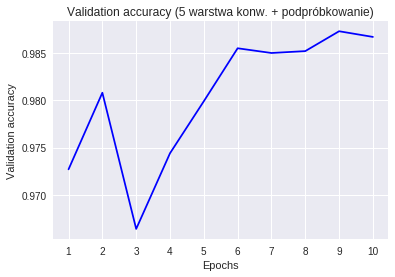

In [70]:
### Wykres val_acc jako funkcja epoch
val_acc = [scores.epoch_data[i]['val_acc'] for i in range(len(scores.epoch_data))]

epochs = [scores.epoch_data[i]['epoch'] for i in range(len(scores.epoch_data))]

plt.plot(epochs, val_acc, 'b')
plt.title('Validation accuracy (5 warstwa konw. + podpróbkowanie)')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.xticks(np.arange(1, liczba_epok+1, step=1))
plt.show()

# Zadanie B - funkcje aktywacji

Narysuj wykres zależności accuracy dla danych **walidacyjnych** od liczby epok, dla sieci konwolucyjnej: 
32-3x3, podpróbkowanie x2, 32-3x3, podpróbkowanie x2, 32-3x3, z wartstwami pełnymi: 128, 256, 10

(przez 32-3x3 rozumiemy warstwę konwolucyjną z 32 filtrami rozmiaru 3x3)

w zależności od funkcji aktywacji (ustawianej w parametrze `activation=`):
* `'relu'`
* `'sigmoid'`
* `'elu'`

** Uwaga! ** Nie należy zmieniać funkcji aktywacji `softmax` w ostatniej warstwie.

In [75]:
liczba_epok = 10
wyniki = {}

for f_aktywacji in ["relu", "sigmoid", "elu"]:
  tf.reset_default_graph()
  tf.logging.set_verbosity(tf.logging.ERROR)

  ### Warstwy odtąd
  network = input_data(shape=[None, 28, 28, 1], name='input')

  network = conv_2d(network, 32, 3, activation=f_aktywacji, regularizer="L2")
  network = max_pool_2d(network, 2)
  network = conv_2d(network, 32, 3, activation=f_aktywacji, regularizer="L2")
  network = max_pool_2d(network, 2)
  network = conv_2d(network, 32, 3, activation=f_aktywacji, regularizer="L2")

  network = fully_connected(network, 128, activation=f_aktywacji) 
  network = fully_connected(network, 256, activation=f_aktywacji)

  network = fully_connected(network, 10, activation='softmax')
  ### Warstwy dotąd

  network = regression(network, optimizer='adam', learning_rate=0.01,
                       batch_size=250,
                       loss='categorical_crossentropy', name='target')
  
  ### Proces trenowania
  scores = Stats(examples=len(X))
  model = tflearn.DNN(network, tensorboard_verbose=0)
  model.fit({'input': X}, {'target': Y},
            n_epoch=liczba_epok, 
            validation_set=({'input': testX}, {'target': testY}), show_metric=True, callbacks=[scores])
  
  wyniki[f_aktywacji] = [scores.epoch_data[i]['val_acc'] for i in range(len(scores.epoch_data))]
  
    
epochs = [scores.epoch_data[i]['epoch'] for i in range(len(scores.epoch_data))]
wyniki
  
  

---------------------------------
Run id: P8E81P
Log directory: /tmp/tflearn_logs/
---------------------------------
Training samples: 55000
Validation samples: 10000
--
Epoch 1, step (batch no.): 1 -- acc: 0.00, loss 0.00 -- iter 00250/55000, training for: 0.23s
Epoch 1, step (batch no.): 66 -- acc: 0.96, loss 0.14 -- iter 16500/55000, training for: 1.24s
Epoch 1, step (batch no.): 135 -- acc: 0.97, loss 0.09 -- iter 33750/55000, training for: 2.25s
Epoch 1, step (batch no.): 203 -- acc: 0.98, loss 0.07 -- iter 50750/55000, training for: 3.25s
Training Step: 220  | total loss: 0.07710 | time: 4.543s
| Adam | epoch: 001 | loss: 0.07710 - acc: 0.9778 | val_loss: 0.09034 - val_acc: 0.9739 -- iter: 55000/55000
--
Epoch 1, step (batch no.): 220 -- acc: 0.98, loss 0.08 -- iter 55000/55000, training for: 4.55s
Epoch 2, step (batch no.): 289 -- acc: 0.98, loss 0.07 -- iter 17250/55000, training for: 5.55s
Epoch 2, step (batch no.): 358 -- acc: 0.98, loss 0.07 -- iter 34500/55000, training for

Training Step: 1320  | total loss: 2.30039 | time: 4.251s
| Adam | epoch: 006 | loss: 2.30039 - acc: 0.1155 | val_loss: 2.30201 - val_acc: 0.1135 -- iter: 55000/55000
--
Epoch 6, step (batch no.): 1320 -- acc: 0.12, loss 2.30 -- iter 55000/55000, training for: 25.56s
Epoch 7, step (batch no.): 1389 -- acc: 0.11, loss 2.30 -- iter 17250/55000, training for: 26.57s
Epoch 7, step (batch no.): 1458 -- acc: 0.11, loss 2.30 -- iter 34500/55000, training for: 27.57s
Epoch 7, step (batch no.): 1527 -- acc: 0.11, loss 2.30 -- iter 51750/55000, training for: 28.58s
Training Step: 1540  | total loss: 2.30267 | time: 4.226s
| Adam | epoch: 007 | loss: 2.30267 - acc: 0.1043 | val_loss: 2.30137 - val_acc: 0.1135 -- iter: 55000/55000
--
Epoch 7, step (batch no.): 1540 -- acc: 0.10, loss 2.30 -- iter 55000/55000, training for: 29.79s
Epoch 8, step (batch no.): 1609 -- acc: 0.11, loss 2.30 -- iter 17250/55000, training for: 30.80s
Epoch 8, step (batch no.): 1678 -- acc: 0.11, loss 2.30 -- iter 34500/55

{'elu': [0.9817999988794327,
  0.9749999970197678,
  0.9615999966859817,
  0.9822999984025955,
  0.976199996471405,
  0.9844999983906746,
  0.9798999994993209,
  0.9578999981284142,
  0.9693999946117401,
  0.9786999955773353],
 'relu': [0.973899994790554,
  0.9839999958872795,
  0.9850000023841858,
  0.9846000015735626,
  0.9855999991297721,
  0.9789999991655349,
  0.983899998664856,
  0.9879000008106231,
  0.9869000002741813,
  0.9836999997496605],
 'sigmoid': [0.11350000016391278,
  0.11350000016391278,
  0.11350000016391278,
  0.11350000016391278,
  0.10100000090897084,
  0.11350000016391278,
  0.11350000016391278,
  0.11350000016391278,
  0.11350000016391278,
  0.11350000016391278]}

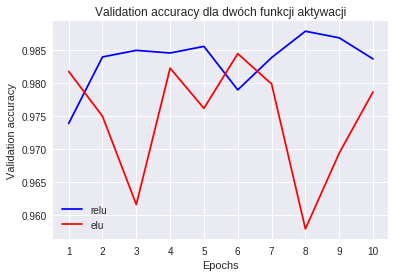

In [83]:
plt.plot(epochs, wyniki['relu'], 'b', label = "relu")
plt.plot(epochs, wyniki['elu'], 'r', label = "elu")
plt.title('Validation accuracy dla dwóch funkcji aktywacji')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.xticks(np.arange(1, liczba_epok+1, step=1))
plt.legend()
plt.show()

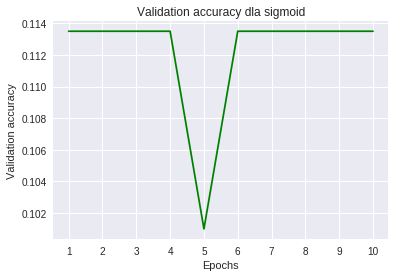

In [84]:
plt.plot(epochs, wyniki['sigmoid'], 'g')
plt.title('Validation accuracy dla sigmoid')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.xticks(np.arange(1, liczba_epok+1, step=1))
plt.show()

# Zadanie C: overfitting
Narysuj wykres zależności accuracy dla danych **treningowych** i **walidacyjnych** od liczby epok (50 epok), dla sieci która ma tylko jedną ukrytą pełną warstwę z 1000 neuronów z aktywacją `relu` i warstwę wyjściową z 10 neuronami. 

Obliczenia wykonaj używając tylko 1000 pierwszych próbek z zestawu treningowego, jak pokazano poniżej:

In [0]:
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.ERROR)

### Warstwy odtąd
network = input_data(shape=[None, 28, 28, 1], name='input')

network = fully_connected(network, 1000, activation='relu')

network = fully_connected(network, 10, activation='softmax')
### Warstwy dotąd

network = regression(network, optimizer='adam', learning_rate=0.01,
                       batch_size=250,
                       loss='categorical_crossentropy', name='target')



In [88]:
scores = Stats(1000)
model = tflearn.DNN(network, tensorboard_verbose=0)
model.fit({'input': X[:1000]}, {'target': Y[:1000]}, n_epoch=50,
           validation_set=({'input': testX}, {'target': testY}), show_metric=True, callbacks=[scores])


---------------------------------
Run id: J1N6JC
Log directory: /tmp/tflearn_logs/
---------------------------------
Training samples: 1000
Validation samples: 10000
--
Epoch 1, step (batch no.): 1 -- acc: 0.00, loss 0.00 -- iter 00250/01000, training for: 0.09s
Training Step: 4  | total loss: 2.39839 | time: 1.137s
| Adam | epoch: 001 | loss: 2.39839 - acc: 0.3569 | val_loss: 1.51403 - val_acc: 0.5396 -- iter: 1000/1000
--
Epoch 1, step (batch no.): 4 -- acc: 0.36, loss 2.40 -- iter 01000/01000, training for: 1.14s
Training Step: 8  | total loss: 1.85270 | time: 1.033s
| Adam | epoch: 002 | loss: 1.85270 - acc: 0.5121 | val_loss: 0.86010 - val_acc: 0.7364 -- iter: 1000/1000
--
Epoch 2, step (batch no.): 8 -- acc: 0.51, loss 1.85 -- iter 01000/01000, training for: 2.17s
Training Step: 12  | total loss: 0.63735 | time: 1.038s
| Adam | epoch: 003 | loss: 0.63735 - acc: 0.8222 | val_loss: 0.54723 - val_acc: 0.8494 -- iter: 1000/1000
--
Epoch 3, step (batch no.): 12 -- acc: 0.82, loss 0.64

Training Step: 148  | total loss: 0.72992 | time: 1.035s
| Adam | epoch: 037 | loss: 0.72992 - acc: 0.9001 | val_loss: 0.39425 - val_acc: 0.8804 -- iter: 1000/1000
--
Epoch 37, step (batch no.): 148 -- acc: 0.90, loss 0.73 -- iter 01000/01000, training for: 38.56s
Training Step: 152  | total loss: 0.49944 | time: 1.037s
| Adam | epoch: 038 | loss: 0.49944 - acc: 0.9333 | val_loss: 0.36183 - val_acc: 0.8883 -- iter: 1000/1000
--
Epoch 38, step (batch no.): 152 -- acc: 0.93, loss 0.50 -- iter 01000/01000, training for: 39.59s
Training Step: 156  | total loss: 0.34095 | time: 1.038s
| Adam | epoch: 039 | loss: 0.34095 - acc: 0.9557 | val_loss: 0.37180 - val_acc: 0.8858 -- iter: 1000/1000
--
Epoch 39, step (batch no.): 156 -- acc: 0.96, loss 0.34 -- iter 01000/01000, training for: 40.63s
Training Step: 160  | total loss: 0.23073 | time: 1.037s
| Adam | epoch: 040 | loss: 0.23073 - acc: 0.9709 | val_loss: 0.36857 - val_acc: 0.8870 -- iter: 1000/1000
--
Epoch 40, step (batch no.): 160 -- acc

In [92]:
val_acc = [scores.epoch_data[i]['val_acc'] for i in range(len(scores.epoch_data))]
train_acc = [scores.epoch_data[i]['acc'] for i in range(len(scores.epoch_data))]
epochs = [scores.epoch_data[i]['epoch'] for i in range(len(scores.epoch_data))]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

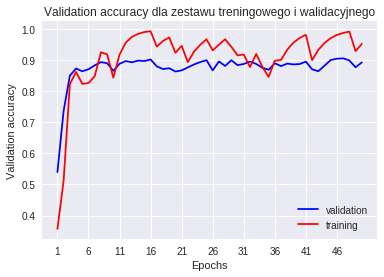

In [94]:
plt.plot(epochs, val_acc, 'b', label = "validation")
plt.plot(epochs, train_acc, 'r', label = "training")
plt.title('Validation accuracy dla zestawu treningowego i walidacyjnego')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.xticks(np.arange(1, len(epochs)+1, step=5))
plt.legend()
plt.show()

# Przesyłanie rozwiązań

Zadania należy wysyłać na adresy `m.matraszek@mimuw.edu.pl` i `t.tajmajer@mimuw.edu.pl` z tytułem o przedrostku [SI18-3]. Termin oddawania rozwiązań to środa 27.06 (+noc).

Przesłane wykresy mogą być w dowolnej formie. Mile widziany byłby odpowiednio zmieniony ten notebook. Poniżej można znaleźć prosty sposób rysowania wykresów.

In [0]:
# Przykład użycia matplotlib do rysowania wykresów:

# Wartości w punktach [0, 1, 2, ...]; podajemy tylko Y
plt.plot([0, 1, 1.5, 6], label="asd")
# X podany w pierwszym argumencie, Y w drugim
plt.plot([0, 2, 6], [7, 0, 0.6], label="bbb")
# rysuje legendę (linie podpisane jako `label`)
plt.legend()

# Zadanie alternatywne

Zamiast rozwiązywania powyższych zadań, proponujemy też kontynuację przygody z OpenAI Gym.
W tej wersji chcielibyśmy użyć dość prostej metody łączącej uczenie ze wzmocnieniem i sieci neuronowe. Jest to Policy Gradient. W miarę przystępny opis tej metody jest zamieszczony tutaj: http://karpathy.github.io/2016/05/31/rl/

Używając tflearn z tą metodą, rozwiąż środowisko CartPole-v0 z OpenAI Gym. A może nawet coś trudniejszego?
Wykonanie:
```python
model.fit({'input': X}, {'target': Y}, n_epoch=1)
```
pozwoli na jednokrotną iterację propagacji wstecznej na podanych danych. Metodę tę można wykonać ponownie z innymi danymi.